# ANÁLISIS DINÁMICO BÁSICO DE CARTERAS

# Análisis de Carteras: Efecto de la Evolución de Precios y el Rebalanceo

Hasta el momento, nuestros estudios de las diferentes estrategias de carteras se han centrado en la selección de activos y la asignación de pesos sin considerar la evolución temporal de los precios de los activos ni la posibilidad de realizar ajustes periódicos o rebalanceo. Estos factores pueden tener un impacto significativo en el rendimiento y el riesgo de las carteras.

En este notebook, exploraremos un análisis básico que incorpora tanto la dinámica de los precios de los activos como la estrategia de rebalanceo. Examinaremos cómo estos elementos afectan la evolución del valor de diferentes carteras a lo largo del tiempo, permitiéndonos obtener una comprensión más profunda de cada estrategia de inversión en un contexto más dinámico y realista. Además, consideraremos el impacto de las comisiones o gastos asociados al rebalanceo, lo que nos permite evaluar de manera más completa el rendimiento neto de las carteras.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp
from tqdm.auto import tqdm
import statsmodels.api as sm
import warnings
from scipy.linalg import sqrtm

plt.style.use('ggplot')
warnings.simplefilter(action='ignore', category=FutureWarning)


c:\Users\danto\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Defino las funciones que calculan los pesos de las distintas carteras

In [2]:
def cartera_min_vol(ret):
    
    ''' Función que calcula la cartera de mínima varianza para un DataFrame de rendimientos
    ret: DataFrame de rendimientos
    Retorna pesos_ajustados: Array con los pesos de la cartera de mínima varianza'''
    
    if isinstance(ret, pd.DataFrame): # Verifico que el argumento sea un DataFrame
    
        num_act = ret.shape[1]
        matriz_cov = ret.cov().to_numpy()
        
            #Variables de decisión
        pesos = cp.Variable(num_act)
        
        #Restricciones
        constraints = [pesos >= 0,
                    cp.sum(pesos) == 1,
                    ]
        
        riesgo = cp.quad_form(pesos, matriz_cov) # Riesgo de la cartera
        objective = cp.Minimize(riesgo) # Minimizar la varianza

        #Problema y resuelvo
        prob = cp.Problem(objective, constraints)
        resultado = prob.solve()

        pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos.value]) #Pongo a cero los pesos menores a 10^-4 y redondeo a 3 decimales

        return pesos_ajustados
    
    else:
        raise ValueError('La función cartera_min_vol solo acepta un DataFrame como argumento') # Si el argumento no es un DataFrame, lanzo un error

In [3]:
def cartera_max_sharpe(ret, ret_rf):
    
    ''' Función que calcula la cartera de máximo índice de Sharpe para un DataFrame de rendimientos
    ret: DataFrame de rendimientos
    ret_rf: Rendimiento del activo libre de riesgo
    Retorna pesos_ajustados: Array con los pesos de la cartera de máximo índice de Sharpe'''
    
    if isinstance(ret, pd.DataFrame):
    
        num_act = ret.shape[1]
        matriz_cov = ret.cov().to_numpy()
        retornos_esperados = ret.mean()

        # Variable de decisión (pesos del portafolio)
        x = cp.Variable(num_act)
        # Riesgo (desviación estándar) del portafolio
        riesgo = cp.quad_form(x, matriz_cov)

        #Cálculo de pi como retornos esperados menos la rantabilidad del activo libre de riesgo
        pi = np.array(retornos_esperados - ret_rf)

        #Restricciones
        constraints = [pi @ x ==1, # para que el numerador sea 1
                    x>=0]       # sin posiciones cortas

        objective = cp.Minimize(riesgo) # Minimizo el riesgo

        # Problema de optimización
        problema = cp.Problem(objective, constraints)        

        # Resolver el problema
        resultado  = problema.solve(solver=cp.ECOS)

        # Normalizo los pesos
        pesos = x.value
        pesos /= pesos.sum()

        pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos])

        return pesos_ajustados
    
    else:
        raise ValueError('La función cartera_max_sharpe solo acepta un DataFrame como argumento')

In [5]:
def cartera_risk_parity(ret):
    
    ''' 
    Función que calcula la cartera de riesgo paridad para un DataFrame de rendimientos
    ret: DataFrame de rendimientos
    Retorna pesos_ajustados: Array con los pesos de la cartera de riesgo paridad'''
    
    if isinstance(ret, pd.DataFrame):
        
        num_act = ret.shape[1]
        matriz_cov = ret.cov().to_numpy()
        retornos_esperados = ret.mean().to_numpy()
        
        b = 1/num_act

        x = cp.Variable(num_act)
        gamma = cp.Variable(num_act, nonneg=True)
        psi = cp.Variable(nonneg=True)

        z = matriz_cov @ x

        obj = cp.pnorm(b**0.5 * psi - gamma, p=2)
        ret = retornos_esperados.T @ x

        constraints = [cp.sum(x) == 1,
                    x >= 0,
                    cp.SOC(psi, sqrtm(matriz_cov) @ x)]

        for i in range(num_act):
            constraints += [cp.SOC(x[i] + z[i],
                                cp.vstack([2*gamma[i], x[i] - z[i]]))
                            ]

        objective = cp.Minimize(obj * 1000)
        prob = cp.Problem(objective, constraints)
        prob.solve()

        pesos_ajustados = np.array([np.round(xi, 3) if xi > 10**-4 else 0 for xi in x.value])

        return pesos_ajustados 
    
    
    else:
        raise ValueError('La función cartera_risk_parity solo acepta un DataFrame como argumento')

In [6]:
start_date = '1995-01-01'
precios_indice = yf.download("SPY", start=start_date)[["Adj Close"]] # Precios ajustados al cierre

[*********************100%%**********************]  1 of 1 completed


In [7]:
filepath = 'https://raw.githubusercontent.com/alfonso-santos/microcredencial-carteras-python-2023/main/Tema_5_APT/data/sp500_tickers.csv'
tickers_sp500 = list(pd.read_csv(filepath))

precios = yf.download(tickers_sp500, start=start_date)['Adj Close']

precios_activos_sp500 = precios.copy()
precios_activos_sp500.dropna(axis=1, inplace=True)
#ret_activos_sp500 = np.log(precios_activos_sp500).diff().dropna()

[*********************100%%**********************]  503 of 503 completed

3 Failed downloads:
['CDAY', 'BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1995-01-01 -> 2024-04-18)')


Elegimos un universo de activos formados por num_act_max activos elegidos aleatoriamente para generar las carteras

In [11]:
num_act_max = 50

num_columnas = precios_activos_sp500.shape[1]

# Generar índices aleatorios para seleccionar num_act_max activos sin repetición

# Fijar la semilla del generador de números aleatorios
np.random.seed(42)  # Puedes usar cualquier número entero como semilla

indices_aleatorios = np.random.choice(num_columnas, size=num_act_max, replace=False)

# Seleccionar las columnas del array original usando los índices aleatorios
precios_activos_select = precios_activos_sp500.iloc[:, indices_aleatorios]



## Evaluación de la Evolución de las Carteras

Vamos a analizar la evolución de diferentes carteras mediante el rebalanceo periódico de las mismas. Este rebalanceo se realizará cada `rebalan_per`, que está medido en meses. Nuestro objetivo es entender cómo estas carteras cambian y se adaptan con el tiempo bajo diferentes condiciones de mercado, lo cual es crucial para optimizar las estrategias de inversión a largo plazo.


In [12]:
retornos = np.log(precios_activos_select).diff().dropna()
retornos.head()

Ticker,MMM,REG,GEN,SO,CNP,AFL,HAS,PPL,TRV,BBY,...,EQR,DHI,INTU,GPC,AEP,STZ,VLO,DHR,WM,RJF
Date,,,,,,,,,,,,,,,,,,,,,
1995-01-04,-0.011642,0.007435,0.014599,0.012500,0.003502,0.030772,0.004320,0.006390,0.000000,0.046884,...,0.000000,0.013793,0.000000,0.003479,0.011343,-0.015293,0.014707,0.009709,0.011174,0.008969
1995-01-05,0.000000,0.000000,-0.067441,-0.006231,0.000000,-0.003795,-0.008659,0.006349,-0.005666,-0.003824,...,-0.030504,-0.013793,0.014815,0.006920,0.000000,0.003419,-0.007327,0.014389,0.000000,0.017700
1995-01-06,-0.004695,0.000000,0.088947,0.006231,0.013889,-0.003810,-0.004357,-0.006349,-0.008560,0.000000,...,0.013188,-0.013985,0.007325,-0.003455,0.007490,0.016921,-0.007380,0.018869,-0.011174,0.000000
1995-01-09,0.000000,0.007379,-0.014286,-0.012500,-0.010398,-0.015385,-0.004377,0.006349,0.011396,-0.011561,...,-0.013188,0.027778,0.000000,0.010327,-0.003738,0.003350,0.000000,-0.002339,-0.011299,-0.035717
1995-01-10,0.000000,-0.022306,-0.021820,0.012500,0.003478,-0.003884,0.004377,0.000000,0.000000,-0.007782,...,0.008812,0.000000,0.003644,0.010222,0.018554,0.023142,0.007380,-0.004695,-0.011428,0.026907


In [13]:
# Agrupar por año y mes y obtener las fechas del primer y último día de cada mes presentes en el índice

fechas_primer_dia = precios_activos_select.groupby([precios_activos_select.index.year, precios_activos_select.index.month]).apply(lambda x: x.index.min()).values
fechas_ultimo_dia = precios_activos_select.groupby([precios_activos_select.index.year, precios_activos_select.index.month]).apply(lambda x: x.index.max()).values

In [14]:
precios_activos_mes_ini = precios_activos_select.loc[fechas_primer_dia]

precios_activos_mes_fin = precios_activos_select.loc[fechas_ultimo_dia]

ret_activos_mes_ini = np.log(precios_activos_mes_ini).diff().dropna()

ret_activos_mes_fin = np.log(precios_activos_mes_fin).diff().dropna()

In [15]:
rebalan_per  = 3 # Periodo de rebalanceo 3 meses
calculo_cartera_per = 60 # Periodo de datos para calcular las carteras 5 años
calculo_inicio_per = 120 # Periodo de datos para calcular la primera cartera para que empiece 31-12

if calculo_cartera_per >= calculo_inicio_per:
    raise ValueError('El periodo de cálculo de la cartera debe ser menor al periodo de inicio de cálculo')

rebalan_fechas = fechas_primer_dia[calculo_inicio_per::rebalan_per]
rebalan_fechas_final = fechas_ultimo_dia[calculo_inicio_per+rebalan_per-1::rebalan_per]

# Por si no hay fecha final para el último periodo de rebalanceo
if (len(rebalan_fechas) > len(rebalan_fechas_final)):
    rebalan_fechas = rebalan_fechas[:-1]


# Calcular la fecha que es 60 meses anterior para cada fecha en el índice
inicio_calc_fechas = pd.Series(rebalan_fechas) - pd.DateOffset(months=calculo_cartera_per)

# Asguro que , para el cáculo de la primera careta, la fecha de inicio sea la primera fecha del índice de los precios mensuales
inicio_calc_fechas[0] = precios_activos_mes_ini.index[0]

In [16]:
precios_rebalan = precios_activos_select.loc[rebalan_fechas]
precios_rebalan_final = precios_activos_select.loc[rebalan_fechas_final]

In [18]:
# Calculo los pesos de la cartera de mínima volatilidad

min_vol_list = []
for i in range(len(rebalan_fechas)):
    pesos_tmp = cartera_min_vol(ret_activos_mes_ini.loc[inicio_calc_fechas[i]: rebalan_fechas[i]])
    min_vol_list.append(pesos_tmp)
    

pesos_ini_min_vol = pd.DataFrame(min_vol_list, columns=ret_activos_mes_fin.columns, index=rebalan_fechas)

In [19]:
# Calculo los pesos de la cartera de max sharpe

ret_rf = 0.01/252 # Tasa libre de riesgo
max_sharpe_list = []
for i in range(len(rebalan_fechas)):
    pesos_tmp = cartera_max_sharpe(ret_activos_mes_fin.loc[inicio_calc_fechas[i]: rebalan_fechas[i]], ret_rf)
    max_sharpe_list.append(pesos_tmp)
    

pesos_ini_max_sharpe = pd.DataFrame(max_sharpe_list, columns=ret_activos_mes_fin.columns, index=rebalan_fechas)

In [20]:
# Calculo los pesos de la cartera risk parity

risk_parity_list = []
for i in range(len(rebalan_fechas)):
    pesos_tmp = cartera_risk_parity(ret_activos_mes_fin.loc[inicio_calc_fechas[i]: rebalan_fechas[i]])
    risk_parity_list.append(pesos_tmp)

pesos_ini_risk_parity = pd.DataFrame(risk_parity_list, columns=ret_activos_mes_fin.columns, index=rebalan_fechas)

In [21]:
# Cáculo el valor de la cartera al final del periodo de rebalanceo
dinero_final_min_vol = (np.array(precios_rebalan_final) * pesos_ini_min_vol)
suma_dinero_final_min_vol = dinero_final_min_vol.sum(axis=1)

dinero_final_max_sharpe = (np.array(precios_rebalan_final) * pesos_ini_max_sharpe)
suma_dinero_final_max_sharpe = dinero_final_max_sharpe.sum(axis=1)

dinero_final_risk_parity = (np.array(precios_rebalan_final) * pesos_ini_risk_parity)
suma_dinero_final_risk_parity = dinero_final_risk_parity.sum(axis=1)

In [22]:
dinero_final_min_vol.sum(axis=1)

2005-01-03     22.501780
2005-04-01     24.934623
2005-07-01     24.701940
2005-10-03     22.042215
2006-01-03     24.559153
                 ...    
2023-01-03     97.645709
2023-04-03    107.307316
2023-07-03     91.170645
2023-10-02    123.202153
2024-01-02    141.801218
Length: 77, dtype: float64

In [23]:
dinero_final_min_vol.pct_change()

Ticker,MMM,REG,GEN,SO,CNP,AFL,HAS,PPL,TRV,BBY,...,EQR,DHI,INTU,GPC,AEP,STZ,VLO,DHR,WM,RJF
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-01,3.416251,-1.0,NaN,0.413155,NaN,0.849868,-0.744631,NaN,NaN,-1.0,...,2.717953,NaN,0.374153,-1.000000,NaN,5.391318,NaN,NaN,NaN,NaN
2005-07-01,-0.423587,NaN,NaN,-0.041629,NaN,1.176369,0.898193,NaN,NaN,NaN,...,0.235976,NaN,-0.917221,NaN,NaN,-0.272532,NaN,NaN,NaN,NaN
2005-10-03,-0.565065,NaN,NaN,0.210045,NaN,0.302109,3.901865,NaN,NaN,NaN,...,-0.365226,NaN,14.463066,inf,NaN,0.047648,NaN,inf,NaN,NaN
2006-01-03,2.826828,NaN,inf,-0.108536,NaN,-0.162430,-1.000000,NaN,NaN,NaN,...,0.170563,NaN,-1.000000,8.301219,NaN,0.273351,inf,-1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,NaN,NaN,-0.455795,-0.753865,NaN,NaN,-0.009336,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.515213,NaN
2023-04-03,NaN,NaN,-0.956422,-1.000000,NaN,NaN,0.159212,NaN,inf,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.815960,NaN
2023-07-03,NaN,NaN,12.426646,NaN,NaN,NaN,0.109583,NaN,-0.158851,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN
2023-10-02,NaN,NaN,-1.000000,NaN,NaN,NaN,-0.324513,NaN,3.104927,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN


In [24]:
retornos_min_vol = suma_dinero_final_min_vol.pct_change().dropna()
retornos_max_sharpe = suma_dinero_final_max_sharpe.pct_change().dropna()
retornos_risk_parity = suma_dinero_final_risk_parity.pct_change().dropna()

In [25]:
precios_indice_fin = precios_indice.loc[rebalan_fechas_final]['Adj Close'][:-1]

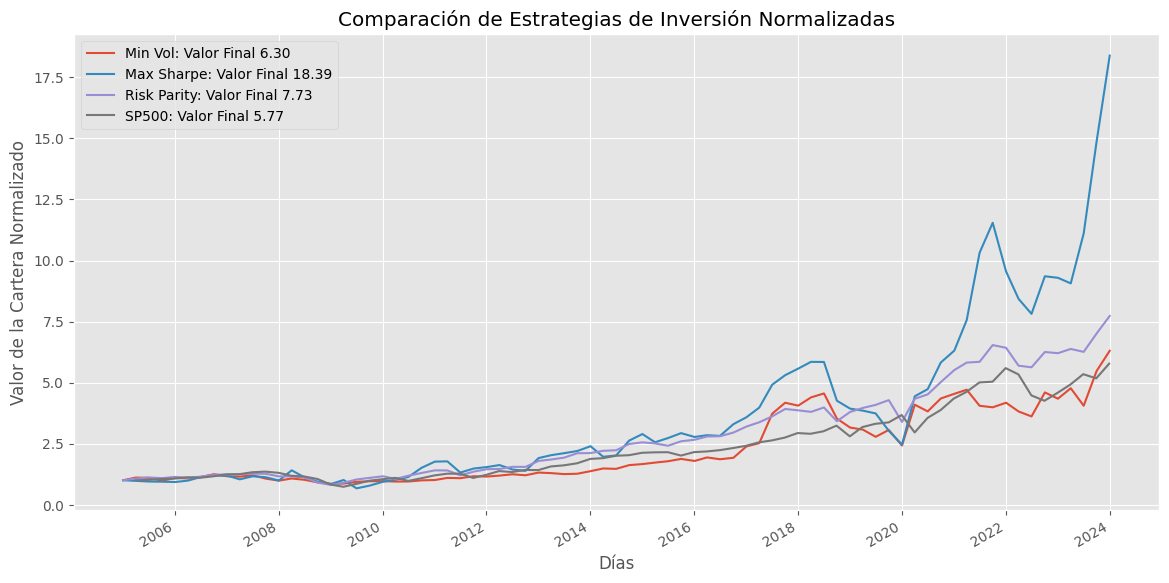

In [26]:
# Normalización de las series: cada serie dividida por su primer valor
norm_min_vol = suma_dinero_final_min_vol / suma_dinero_final_min_vol[0]
norm_max_sharpe = suma_dinero_final_max_sharpe / suma_dinero_final_max_sharpe[0]
norm_risk_parity = suma_dinero_final_risk_parity / suma_dinero_final_risk_parity[0]
norm_indice = pd.Series(precios_indice_fin/precios_indice_fin.iloc[0])

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(14, 7))

# Dibujar cada serie en el mismo gráfico, con etiquetas que incluyen el último valor de cada serie
norm_min_vol.plot(ax=ax, label=f'Min Vol: Valor Final {norm_min_vol.iloc[-1]:.2f}')
norm_max_sharpe.plot(ax=ax, label=f'Max Sharpe: Valor Final {norm_max_sharpe.iloc[-1]:.2f}')
norm_risk_parity.plot(ax=ax, label=f'Risk Parity: Valor Final {norm_risk_parity.iloc[-1]:.2f}')
norm_indice.plot(ax=ax, label=f'SP500: Valor Final {norm_indice.iloc[-1]:.2f}')

# Añadir título y etiquetas
ax.set_title('Comparación de Estrategias de Inversión Normalizadas')
ax.set_xlabel('Días')
ax.set_ylabel('Valor de la Cartera Normalizado')

# Añadir leyenda
ax.legend()

# Mostrar la gráfica
plt.show()

In [27]:
print(f' La volatilidad de la caretra de mínima volatilidad es {np.std(retornos_min_vol):.2f}')
print(f' La volatilidad de la carteras de máximo sharpe es {np.std(retornos_max_sharpe):.2f}')
print(f' La volatilidad de la cartera de risk parity es {np.std(retornos_risk_parity):.2f}')

 La volatilidad de la caretra de mínima volatilidad es 0.13
 La volatilidad de la carteras de máximo sharpe es 0.18
 La volatilidad de la cartera de risk parity es 0.08


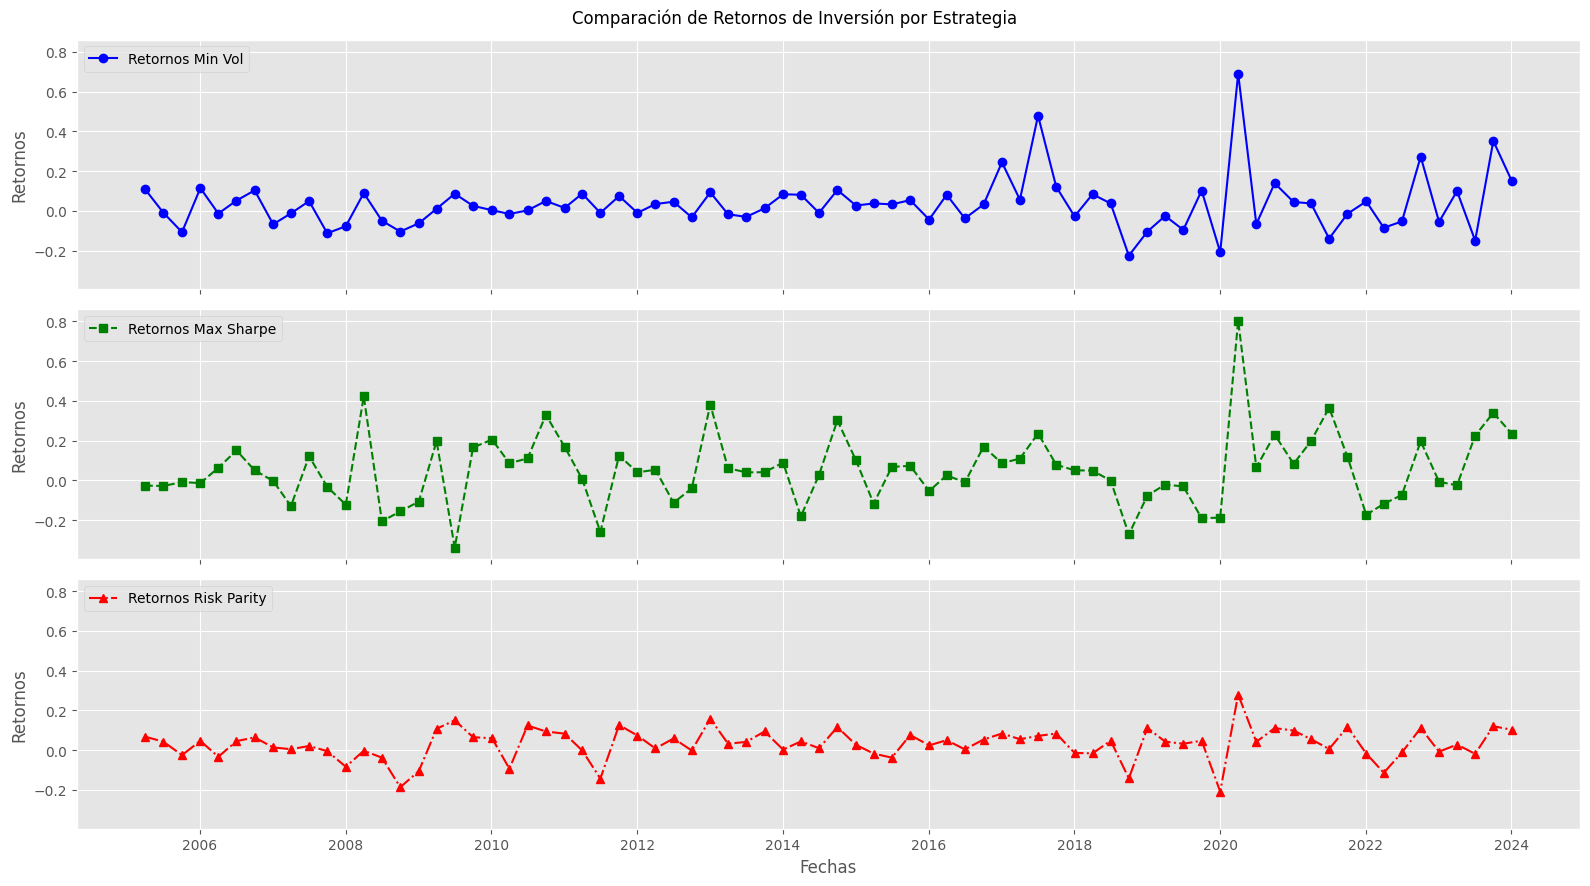

In [28]:
# Crear una figura y subgráficas
fig, axs = plt.subplots(3, 1, figsize=(16, 9), sharex=True, sharey= True)  # 3 subgráficas, una para cada estrategia, compartiendo el eje x

# Dibujar cada serie de retornos en su propia subgráfica
axs[0].plot(retornos_min_vol, label='Retornos Min Vol', marker='o', linestyle='-', color='blue')
axs[1].plot(retornos_max_sharpe, label='Retornos Max Sharpe', marker='s', linestyle='--', color='green')
axs[2].plot(retornos_risk_parity, label='Retornos Risk Parity', marker='^', linestyle='-.', color='red')

# Añadir título general y etiquetas
fig.suptitle('Comparación de Retornos de Inversión por Estrategia')
for ax in axs:
    ax.set_ylabel('Retornos')
    ax.legend(loc='upper left')  # Colocar leyenda en la parte superior izquierda

# Etiqueta para el eje x solo en la subgráfica inferior
axs[2].set_xlabel('Fechas')

# Ajustar automáticamente el layout
fig.tight_layout()  # Ajusta la subgráfica para dejar espacio para el título general

# Mostrar la gráfica
plt.show()


## Resumen del Análisis de Rebalanceo y Variabilidad en los Pesos de los Activos

Nuestro análisis previo se centró en observar cómo el valor de las carteras cambia a lo largo del tiempo, sin abordar las transacciones de rebalanceo necesarias para mantener las estrategias de asignación de activos. Estas transacciones son cruciales, ya que influyen significativamente en los costos operativos y el rendimiento total de la cartera.

Además, nos enfocaremos en la variabilidad de los pesos asignados a cada activo durante los rebalanceos. Para ello, calcularemos y analizaremos la diferencia entre el peso más alto y el más bajo registrado por cada activo a lo largo de todos los periodos de rebalanceo. Este análisis nos ayudará a entender la volatilidad en la asignación de los activos y evaluar cómo los ajustes frecuentes pueden afectar la estabilidad y eficiencia de nuestras estrategias de inversión.





In [2]:
#TODO